In [9]:
import fiona
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely import wkt, MultiPolygon, Point
from geoalchemy2 import Geometry, WKTElement
import requests
from io import BytesIO
from os import path
from sqlalchemy import create_engine, text
import psycopg2
import psycopg2.extras
import json
from sklearn.decomposition import PCA
from scipy.stats import zscore, ttest_ind, spearmanr
import matplotlib.pyplot as plt
import folium
from folium.features import GeoJsonTooltip
from scipy.stats import pearsonr

In [10]:
# Please fill in correct details
credentials = "references/credentials.json"

# Connecttion to database
def pgconnect(credential_filepath, db_schema="public"):
    with open(credential_filepath) as f:
        db_conn_dict = json.load(f)
        host       = db_conn_dict['host']
        db_user    = db_conn_dict['user']
        db_pw      = db_conn_dict['password']
        default_db = db_conn_dict['user']
        try:
            db = create_engine('postgresql+psycopg2://'+db_user+':'+db_pw+'@'+host+'/'+default_db, echo=False)
            conn = db.connect()
            print('Connected successfully.')
        except Exception as e:
            print("Unable to connect to the database.")
            print(e)
            db, conn = None, None
        return db, conn

# Output query to Pandas DataFrame
def query(conn, sqlcmd, args=None, df=True):
    result = pd.DataFrame() if df else None
    try:
        if df:
            result = pd.read_sql_query(sqlcmd, conn, params=args)
        else:
            result = conn.execute(sqlcmd, args).fetchall()
            result = result[0] if len(result) == 1 else result
    except Exception as e:
        print("Error encountered: ", e, sep='\n')
    return result

In [11]:
srid = 4326
type_dict = {MultiPolygon: 'MultiPolygon', Point: 'Point'}

# Generate WKT from a Shapely Geometry
def create_wkt_element(geom, Type, srid=4326):
    type_str = type_dict[Type]
    if geom.geom_type != type_str:
        geom = Type([geom])
    return WKTElement(geom.wkt, srid)

In [12]:
# Scrape Childcare Data
def scrape_childcare_data(url):
    response = requests.get(url)

    if response.status_code == 200:
        file = BytesIO(response.content)
        df = pd.read_excel(file)
        # print(df.head())

        # Save the DataFrame as a CSV file
        df.to_csv("data/external/childcare_facilities.csv", index=False)
        print('Success')
    else:
        raise FileNotFoundError(f"Failed to fetch the data from the URL. Status code: {response.status_code}")

# Save childcare data to csv if it does not exist
if not path.exists("data/external/childcare_facilities.csv"):
    scrape_childcare_data("https://shorturl.at/jkQT7")
else:
    print(f'childcare_facilities.csv already exists')

childcare_facilities.csv already exists


In [13]:
# Convert all raw and external data to DataFrames and GeoDataFrames

with fiona.open('data/raw/SA2_2021_AUST_SHP_GDA2020') as fiona_file:
    raw_sa_gdf = gpd.GeoDataFrame.from_features([feature for feature in fiona_file])
    
with fiona.open('data/raw/catchments') as fiona_file:
    raw_catchments_gdf = gpd.GeoDataFrame.from_features([feature for feature in fiona_file])
    
raw_business_df = pd.read_csv('data/raw/Businesses.csv', )
raw_income_df = pd.read_csv('data/raw/Income.csv')
raw_polling_df = pd.read_csv('data/raw/PollingPlaces2019.csv')
raw_population_df = pd.read_csv('data/raw/Population.csv')
raw_stops_df = pd.read_csv('data/raw/Stops.txt')
raw_childcare_df = pd.read_csv('data/external/childcare_facilities.csv')
raw_poi_gdf = gpd.read_file('data/external/Points_Of_Interest.json')

In [14]:
# Split SA2 data into geometry and info datafranes
sa2_geometry_gdf = raw_sa_gdf.loc[raw_sa_gdf['GCC_NAME21']=='Greater Sydney',['SA2_CODE21', 'geometry']]  \
                             .rename(columns={'SA2_CODE21':'sa2_code'})
sa2_info_df =  pd.DataFrame(raw_sa_gdf.loc[raw_sa_gdf['GCC_NAME21']=='Greater Sydney',['SA2_CODE21', 'SA2_NAME21', 'AREASQKM21']] \
                            .rename(columns={'SA2_CODE21':'sa2_code', 'SA2_NAME21':'sa2_name', 'AREASQKM21':'area'}))

# Creates list of SA2 codes in Greater Sydney
sa2_code_list = list(sa2_info_df.sa2_code)

# Cleans school catchments data
catchments_gdf = raw_catchments_gdf.rename(columns={'USE_ID':'school_id'}).loc[:, ['school_id', 'geometry']]

# Cleans business counts dataframe by normalising and converting the industry code into an integer index
business_counts_df = raw_business_df.loc[raw_business_df['sa2_code'].astype(str).isin(sa2_code_list), 
                                         ['industry_code', 'sa2_code', 'total_businesses']]
labels, levels = pd.factorize(business_counts_df['industry_code'])
business_counts_df['industry_code'] = labels

# Generates mapping table for industry code and name
industry_names_df = pd.DataFrame(levels, columns=['industry_code'])
industry_names_df = industry_names_df.merge(raw_business_df.loc[:, ['industry_code', 'industry_name']].drop_duplicates())
industry_names_df['industry_code'] = industry_names_df.index

# Cleans income data
income_df = raw_income_df.loc[raw_income_df['sa2_code'].astype(str).isin(sa2_code_list)].drop(columns=['sa2_name'])
income_df = income_df.replace({'np': np.nan}).dropna()

# Cleans polling data
polling_gdf = raw_polling_df.loc[~(raw_polling_df['longitude'].isna()) & ~(raw_polling_df['latitude'].isna()), 
                                 ['polling_place_id', 'longitude', 'latitude']].reset_index(drop=True)
polling_gdf = gpd.GeoDataFrame(polling_gdf, 
                               geometry=gpd.points_from_xy(pd.to_numeric(polling_gdf.longitude), 
                                                           pd.to_numeric(polling_gdf.latitude)))
polling_gdf.drop(columns=['latitude','longitude'], inplace=True)

# Cleans population data
population_df = raw_population_df.loc[:, ['sa2_code', 'total_people']].rename(columns={'total_people': 'total_population'})
population_df['young_people_population'] = raw_population_df['0-4_people'] + raw_population_df['5-9_people'] + \
                                           raw_population_df['10-14_people'] +  raw_population_df['15-19_people']

# Cleans stop data
# Stop is defined by having a missing location_type
stops_gdf = raw_stops_df.loc[raw_stops_df['location_type'].isna(), ['stop_id', 'stop_lon', 'stop_lat']].reset_index(drop=True)
stops_gdf['geometry'] = gpd.GeoSeries(gpd.points_from_xy(stops_gdf['stop_lon'].astype(float), stops_gdf['stop_lat'].astype(float)))
stops_gdf = gpd.GeoDataFrame(stops_gdf, geometry='geometry').drop(columns=['stop_lat', 'stop_lon'])

# Clean childcare data
childcare_geometry = gpd.points_from_xy(raw_childcare_df['LONGITUDE'], raw_childcare_df['LATITUDE'])
childcare_gdf = gpd.GeoDataFrame(raw_childcare_df.ID, geometry=childcare_geometry).rename(columns={'ID': 'childcare_id'})

# Clean libraries data
libraries_gdf = raw_poi_gdf.loc[raw_poi_gdf['poitype']=='Library', ['topoid','geometry']]
libraries_gdf.rename(columns={'topoid': 'library_id'}, inplace=True)

In [15]:
# Converting GeoDataFrames to  have WKT column rather than Shapely Geometries
sa2_geometry_gdf_for_sql = sa2_geometry_gdf.copy()
catchments_gdf_for_sql = catchments_gdf.copy()
polling_gdf_for_sql = polling_gdf.copy()
stops_gdf_for_sql = stops_gdf.copy()
childcare_gdf_for_sql = childcare_gdf.drop_duplicates(subset=['childcare_id']).copy()
libraries_gdf_for_sql = libraries_gdf.copy()

gdfs_to_convert = [
    (sa2_geometry_gdf_for_sql, MultiPolygon), 
    (catchments_gdf_for_sql, MultiPolygon),
    (polling_gdf_for_sql, Point),
    (stops_gdf_for_sql, Point),
    (childcare_gdf_for_sql, Point),
    (libraries_gdf_for_sql, Point)
]

for gdf, type in gdfs_to_convert:
    gdf['geom'] = gdf['geometry'].apply(lambda x: create_wkt_element(x, type, srid=srid))

In [16]:
# Try to close any open connection
try:
    conn.close()
    db.dispose()
except Exception as e:
    print('No connection to close.')

# Connect to database
db, conn = pgconnect(credentials)
conn.execute(text("set search_path to public"))

No connection to close.
Connected successfully.


In [17]:
# Generate scheme
with open('sql/schema.sql') as file:
    sql_scheme_string = text(file.read())

conn.execute(sql_scheme_string)

In [18]:
# Upload dataframes to SQL Server
gdf_to_upload = [
    (sa2_geometry_gdf_for_sql, 'MULTIPOLYGON', 'sa2_geometry'), 
    (catchments_gdf_for_sql, 'MULTIPOLYGON', 'catchments'),
    (polling_gdf_for_sql, 'POINT', 'polling_places'),
    (stops_gdf_for_sql, 'POINT', 'stops'),
    (childcare_gdf_for_sql, 'POINT', 'childcare_facilities'),
    (libraries_gdf_for_sql, 'POINT', 'libraries')
]

for gdf, type, table in gdf_to_upload:
    gdf[[col for col in gdf.columns if col != 'geometry']].to_sql(table, 
                                                                  conn, 
                                                                  if_exists='append', 
                                                                  index=False, 
                                                                  dtype={'geom': Geometry(type, srid)})

dfs_to_upload = [
    (sa2_info_df, 'sa2_info'),
    (industry_names_df, 'industry_names'),
    (business_counts_df, 'business_counts'),
    (income_df, 'incomes'),
    (population_df, 'populations')
]

for df, table in dfs_to_upload:
    df.to_sql(table, conn, if_exists='append', index=False)

In [19]:
# Generate indexes
with open('sql/indexes.sql') as file:
    sql_index_string = text(file.read())

conn.execute(sql_index_string)

In [20]:
# Creates intermin views for simipler queries
conn.execute(text('set search_path to public'))
with open('sql/views.sql', 'r') as file:
    view_sql_string = text(file.read())

conn.execute(view_sql_string)

In [21]:
# Generates weights for the scores based on a PCA
df_for_pca = query(conn, 'select * from metrics')

df_for_pca = df_for_pca.drop(columns=['sa2_code', 'sa2_name', 'geom', 'area', 'young_people_population', 'total_count']).apply(zscore)

cols = list(df_for_pca.columns)

df_for_pca = df_for_pca.to_numpy()

pca = PCA(n_components=1)

pca.fit(df_for_pca)
weights = pca.components_.tolist()

weight_dic = {}
for col_name, weight in zip(cols, weights[0]):
        print(f'{col_name} weight: {weight}')
        weight_dic[f'{col_name}_weight'] = str(weight)
        

polls weight: 0.36725888233772297
stops weight: 0.3542459899107671
schools weight: 0.31043876860537345
retail weight: 0.45075328648827917
health weight: 0.4382001185821598
libraries weight: 0.3236294063075545
childcare_facilities weight: 0.37858235707779997


In [22]:
conn.execute(text('set search_path to public'))
with open('sql/additional_zscore.sql', 'r') as file:
    scores_sql_string = str(file.read())

# Automatically change weight based on the PCA
scores_with_weight_sql_string = scores_sql_string
for weight_name, weight in weight_dic.items():
    scores_with_weight_sql_string = scores_with_weight_sql_string.replace(weight_name, weight)

scores_with_weight_sql_string = text(scores_with_weight_sql_string)

# Create final scores
score_df = query(conn, scores_with_weight_sql_string)
score_df

,sa2_code,sa2_name,z_retail,z_health,z_stops,z_polls,z_schools,z_libraries,z_childcare_facilities,score
0,117031644,Sydney (North) - Millers Point,3.000000,3.000000,2.809414,3.000000,0.805870,3.000000,3.000000,4.581597
1,117031646,Ultimo,3.000000,3.000000,1.030569,0.417729,3.000000,3.000000,3.000000,4.011853
2,117031336,Surry Hills,3.000000,3.000000,1.423987,1.867498,2.408689,3.000000,1.324156,3.919028
3,117031645,Sydney (South) - Haymarket,3.000000,2.993664,3.000000,3.000000,1.601478,-0.516094,1.833040,3.776552
4,119031664,Hurstville - Central,2.584041,2.623310,2.523642,3.000000,1.291662,-0.516094,2.749842,3.606635
...,...,...,...,...,...,...,...,...,...,...
354,123031448,The Oaks - Oakdale,-0.535939,-0.617954,-1.679276,-0.512961,-0.411760,-0.516094,-1.005586,-1.190867
355,102021049,Jilliby - Yarramalong,-0.536844,-0.617091,-1.681643,-0.514921,-0.399354,-0.516094,-1.012735,-1.191148
356,123031446,Douglas Park - Appin,-0.535847,-0.616971,-1.692670,-0.512227,-0.410332,-0.516094,-0.999473,-1.191658
357,102011030,Calga - Kulnura,-0.535650,-0.617517,-1.708646,-0.514678,-0.405235,-0.516094,-1.010732,-1.197620


In [23]:
# Create rank-based scores
conn.execute(text('set search_path to public'))
with open('sql/rank_score.sql', 'r') as file:
    rank_scores_sql_string = text(file.read())

adv_score_df = query(conn, rank_scores_sql_string)
adv_score_df

,sa2_code,sa2_name,score_adv
0,117031644,Sydney (North) - Millers Point,38
1,117031336,Surry Hills,89
2,117031646,Ultimo,92
3,121041417,North Sydney - Lavender Bay,140
4,117031647,Waterloo,163
...,...,...,...
354,102021049,Jilliby - Yarramalong,2250
355,123031446,Douglas Park - Appin,2251
356,102011030,Calga - Kulnura,2259
357,123031448,The Oaks - Oakdale,2261


In [24]:
# Generate data for analysis
data = query(conn, 'select * from scores')
data['sa2_code'] = data['sa2_code'].astype(str)
data = gpd.GeoDataFrame(data.merge(sa2_geometry_gdf), geometry='geometry')

In [25]:
# Calculate and print the descriptive statistics
desc_stats = data.describe()
print(desc_stats)

         z_retail    z_health     z_stops     z_polls   z_schools   
count  359.000000  359.000000  359.000000  359.000000  359.000000  \
mean    -0.046873   -0.037593   -0.005145   -0.050856   -0.056002   
std      0.664962    0.779427    0.979536    0.547044    0.559677   
min     -0.539046   -0.620407   -1.722084   -0.519452   -0.413690   
25%     -0.425639   -0.499030   -0.742134   -0.365874   -0.341368   
50%     -0.263815   -0.332012   -0.013704   -0.207021   -0.262271   
75%      0.017776    0.069311    0.709883    0.067692   -0.022865   
max      3.000000    3.000000    3.000000    3.000000    3.000000   

       z_libraries  z_childcare_facilities         score  
count   359.000000              359.000000  3.590000e+02  
mean     -0.034971               -0.023012  1.979228e-16  
std       0.822502                0.875566  1.000000e+00  
min      -0.516094               -1.012735 -1.205124e+00  
25%      -0.516094               -0.700676 -7.010030e-01  
50%      -0.516094      

In [26]:
# Define matplotlib style
plt.style.use('references/rose-pine-dawn.mplstyle')

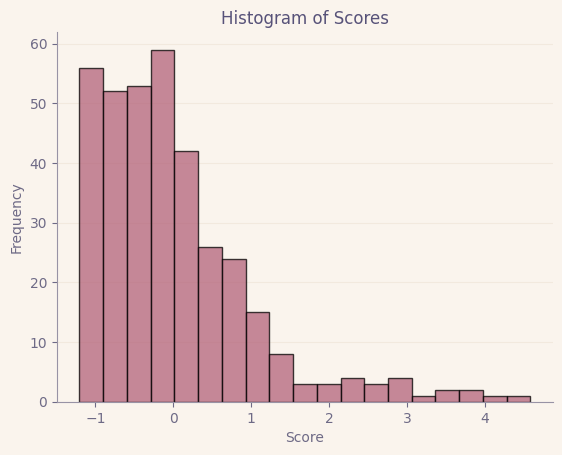

In [27]:
# Create a histogram showing the overall distribution of scores
plt.hist(data['score'], bins='auto', edgecolor='black', alpha=0.75)
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title('Histogram of Scores')
plt.show()

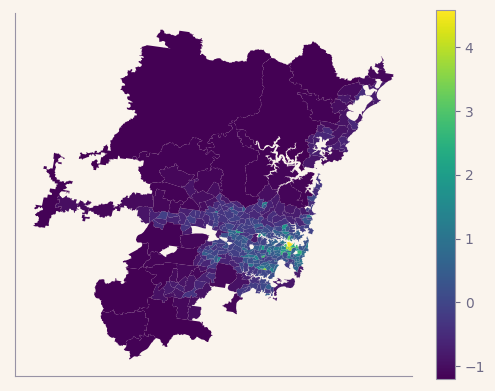

In [28]:
# Plot the heatmap of scores
fig, ax = plt.subplots()
data.plot(column='score', cmap='viridis', legend=True, ax=ax)
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [29]:
# Read the income file
incomes_df = query(conn, 'select * from incomes')
incomes_df['sa2_code'] = incomes_df['sa2_code'].astype(str)

# Merge the dataframes on the sa2_code column
merged_df = pd.merge(data, incomes_df, on='sa2_code', how='inner')

# Convert the median_income column to float
merged_df['median_income'] = merged_df['median_income'].astype(float)

# Calculate the correlation coefficient
corr_coeff = merged_df['score'].corr(merged_df['median_income'])

print(f'Correlation coefficient between score and median_income: {corr_coeff}')

Correlation coefficient between score and median_income: 0.2929571782297724


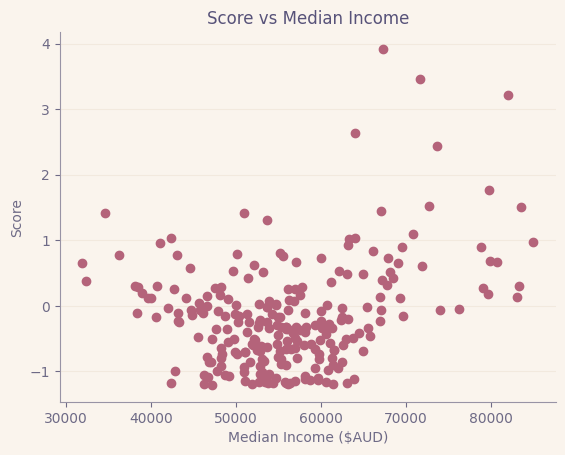

In [30]:
# Plot income scatterplot
fig, ax = plt.subplots()
ax.scatter(merged_df['median_income'], merged_df['score'])
ax.set_xlabel('Median Income ($AUD)')
ax.set_ylabel('Score')
ax.set_title('Score vs Median Income')
plt.show()

In [31]:
# Create an R-tree spatial index
spatial_index = data.sindex

# Find the top-scoring areas
top_scoring_areas = data.nlargest(10, 'score')

# Find adjacent areas to the top-scoring areas
adjacent_areas = set()
for _, top_area in top_scoring_areas.iterrows():
    possible_neighbors = list(spatial_index.intersection(top_area.geometry.bounds))
    for neighbor_index in possible_neighbors:
        # Check if the neighboring area's boundary intersects the top-scoring area's boundary
        if data.loc[neighbor_index].geometry.touches(top_area.geometry):
            adjacent_areas.add(neighbor_index)

# Calculate the average score for the adjacent areas
adjacent_areas_data = data.loc[list(adjacent_areas)]
avg_score_adjacent = adjacent_areas_data['score'].mean()

# Calculate the average score for all areas
avg_score_all = data['score'].mean()

print(f"Average score for adjacent areas: {avg_score_adjacent}")
print(f"Average score for all areas: {avg_score_all}")

# Perform an independent two-sample t-test
t_statistic, p_value = ttest_ind(adjacent_areas_data['score'], data['score'], equal_var=False)

print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}")

# Set a significance level
alpha = 0.05

if p_value < alpha:
    print("The difference in average scores is statistically significant.")
else:
    print("The difference in average scores is not statistically significant.")

Average score for adjacent areas: 1.7784803267841958
Average score for all areas: 1.9792276762119782e-16
T-statistic: 5.853901742913561
P-value: 5.399420184548275e-06
The difference in average scores is statistically significant.


The Spearman rank correlation coefficient is: 0.9846246816368665


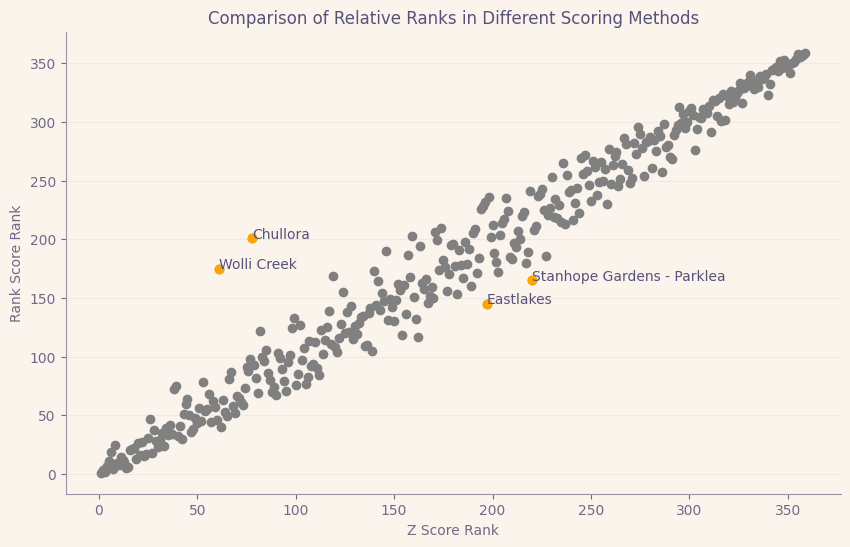

In [32]:
# Load the data
z_score_df = query(conn, 'select * from scores')
rank_score_df = query(conn, 'select * from adv_scores')

# Create index columns
z_score_df['index_z'] = range(1, len(z_score_df) + 1)
rank_score_df['index_adv'] = range(1, len(rank_score_df) + 1)

# Merge the two dataframes based on the index columns
merged_df = pd.merge(z_score_df, rank_score_df, on=['sa2_code', 'sa2_name'])

# Compute Spearman rank correlation
correlation, _ = spearmanr(merged_df['index_z'], merged_df['index_adv'])
print(f"The Spearman rank correlation coefficient is: {correlation}")

# Identify outliers
merged_df['discrepancy'] = abs(merged_df['index_z'] - merged_df['index_adv'])
outliers = merged_df[merged_df['discrepancy'] > 50]

# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(merged_df['index_z'], merged_df['index_adv'], color='gray', label='Data')
plt.scatter(outliers['index_z'], outliers['index_adv'], color='orange', label='Outliers')

# Annotate outliers
for _, row in outliers.iterrows():
    plt.annotate(row['sa2_name'], (row['index_z'], row['index_adv']))

# Customise the plot
plt.xlabel('Z Score Rank')
plt.ylabel('Rank Score Rank')
plt.title('Comparison of Relative Ranks in Different Scoring Methods')
plt.legend().set_visible(False)

plt.show()

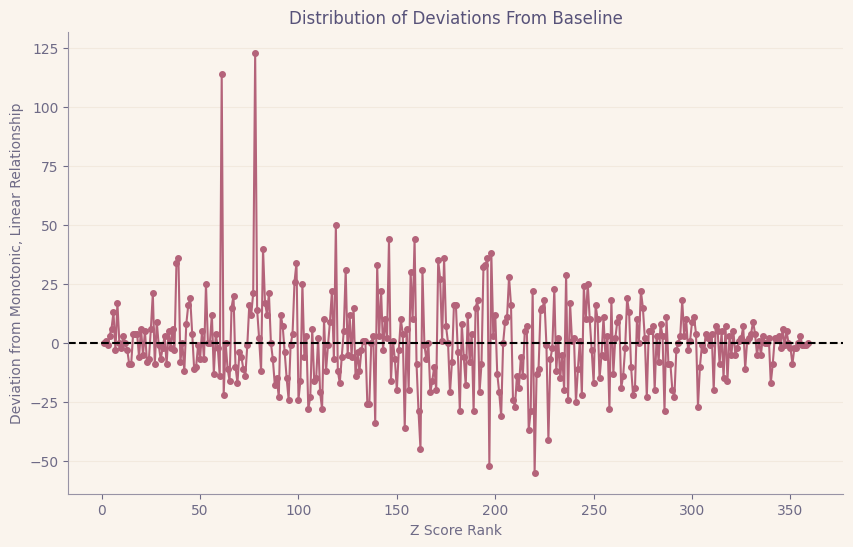

In [33]:
# Compute deviation from the diagonal line y=x
merged_df['deviation'] = merged_df['index_adv'] - merged_df['index_z']

# Create a deviation-from-baseline plot
plt.figure(figsize=(10, 6))
plt.plot(merged_df['index_z'], merged_df['deviation'], linestyle='-', marker='o', markersize=4)
plt.xlabel('Z Score Rank')
plt.ylabel('Deviation from Monotonic, Linear Relationship')
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Distribution of Deviations From Baseline')

plt.show()

Correlation between distance from CBD and score: -0.6542613564698737


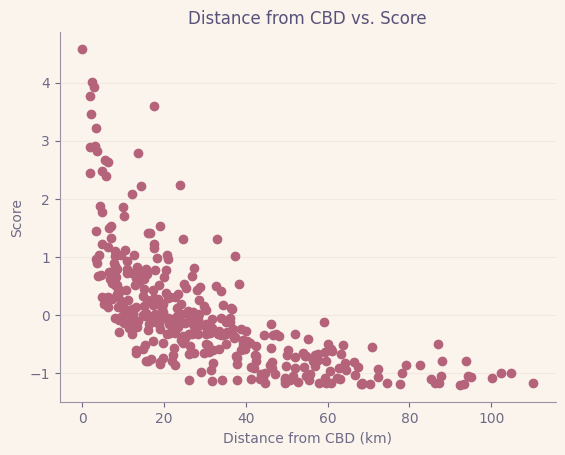

In [34]:
# Read the files
data = query(conn, 'select * from scores')
data['sa2_code'] = data['sa2_code'].astype(str)
merged_data = gpd.GeoDataFrame(data.merge(sa2_geometry_gdf.set_crs(4326), on='sa2_code'), geometry='geometry')

merged_data_proj = merged_data.to_crs(3857)
cbd = merged_data_proj.loc[merged_data['sa2_name'] == 'Sydney (North) - Millers Point']
cbd_centroid = cbd.geometry.centroid.iloc[0]

# Calculate the center of every other polygon
merged_data_proj['centroid'] = merged_data_proj.geometry.centroid

# Calculate the distance between each area's center and the CBD
merged_data_proj['distance_to_cbd'] = merged_data_proj['centroid'].distance(cbd_centroid) / 1000

# Calculate the correlation between the distance from the CBD and the score
correlation, _ = pearsonr(merged_data_proj['distance_to_cbd'], merged_data_proj['score'])
print('Correlation between distance from CBD and score:', correlation)

# Create a scatterplot of distance_to_cbd vs. score
plt.scatter(merged_data_proj['distance_to_cbd'], merged_data_proj['score'])
plt.xlabel('Distance from CBD (km)')
plt.ylabel('Score')
plt.title('Distance from CBD vs. Score')
plt.show()

In [35]:
# Closes any open connection
conn.close()
db.dispose()